# PyTorch Tensors

Understanding tensors is critical to working with PyTorch. My background is in Physics and so I am used to thinking of tensors as mathematical objects that describe a multi-linear map

$u = T_{ijk\dotsb}^{lmn\dotsb}v$

and obey transformation laws like

$T_{i^\prime j^\prime k^\prime \dotsb}^{l^\prime m^\prime n^\prime \dotsb} = \Gamma_{i}^{i^\prime}\Gamma_{j}^{j^\prime}\Gamma_{k}^{k^\prime}\dotsb\Gamma^{l}_{l^\prime}\Gamma^{m}_{m^\prime}\Gamma^{n}_{n^\prime} T_{ijk\dotsb}^{lmn\dotsb}$

Working with PyTorch tensors do require some index gymnastics, but this is not what is explored here. Let's see what the tensors are here.

For instance, how are PyTorch tensors stored?

In [1]:
%matplotlib inline

In [120]:
from collections import Counter
import os
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [3]:
range_t: torch.Tensor = torch.tensor(list(range(9)))

In [4]:
sys.getsizeof(list(range(9)))

128

In [5]:
sys.getsizeof(range_t)

72

It turns out that the size of a tensor is less than constructor inputs! That is because the backend API stores the data in contiguous memory blocks unlike default Python allocating objects and reserving memory pointers.

In [6]:
range_t.is_contiguous()

True

In [7]:
range_t.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 9]

How does indexing work?

In [8]:
range_t.size(), range_t.storage_offset(), range_t.stride()

(torch.Size([9]), 0, (1,))

Since this is a 1D tensor, we are working equivalently with a vector. Moving between elements is unit steps. What if we want to make this a matrix?

In [9]:
range_t_tr: torch.Tensor = range_t.view(3, 3)

In [10]:
range_t_tr

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [11]:
range_t_tr.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 9]

While they are not the same shape, they look like the same in storage.

In [12]:
range_t_tr.storage() == range_t.storage()

False

While the equality operator says the storage containers are not equal, but are the storage elements equal?

In [13]:
assert all(
    z1 == z2
    for (z1, z2) in zip(range_t_tr.storage(), range_t.storage())
)

What about using a different slice? Will the offset and stide be different?

In [14]:
range_t_tr[1:, 1:]

tensor([[4, 5],
        [7, 8]])

In [15]:
range_t_tr[1:, 1:].size(), range_t_tr[1:, 1:].stride(), range_t_tr[1:, 1:].storage_offset()

(torch.Size([2, 2]), (3, 1), 4)

The stride is the same from before, but does not match the tensor size. I guess this is due to the nature of slicing? What does a clone do?

In [16]:
range_t_tr[1:, 1:].clone().stride()

(2, 1)

This is the expected result. So since we are NOT dealing with contiguous memory object, the stride is different.  So we have to make the tensor contiguous (or clone if necessary)

In [17]:
range_t_tr[1:, 1:].contiguous().stride()

(2, 1)

What about applying functions to tensors?

In [18]:
range_t.dtype, range_t.sqrt().dtype

(torch.int64, torch.float32)

These are two different tensors. Like the `list.sort` and `sorted` methods, one method returns a new object and the other inplace, respectively. Let's verify this.

In [19]:
range_t.sqrt_()

RuntimeError: result type Float can't be cast to the desired output type Long

We have to convert the tensor to a floating-point type to perform the square-root operation element-wise and change the object in-place.

In [20]:
range_t.clone().to(torch.float).sqrt_()

tensor([0.0000, 1.0000, 1.4142, 1.7321, 2.0000, 2.2361, 2.4495, 2.6458, 2.8284])

## Tabular Data

Let's play with the Wine Quality dataset https://mng.bz/90Ol

### Data Description

This data frame contains the following columns:

Input variables (based on physicochemical tests):\
1 - fixed acidity\
2 - volatile acidity\
3 - citric acid\
4 - residual sugar\
5 - chlorides\
6 - free sulfur dioxide\
7 - total sulfur dioxide\
8 - density\
9 - pH\
10 - sulphates\
11 - alcohol\
Output variable (based on sensory data):\
12 - quality (score between 0 and 10)

### Discussion

All but the last variable "quality" is an objective variable compared to physiochemical random variates.


In [21]:
wine_file = Path("winequality-white.csv")
with wine_file.open("r") as fh:
    print("Header:", fh.readline())
    print("First line", fh.readline())

Header: "fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"

First line 7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6



We have semi-colon separated values with floats and ints. Using the Pandas DataFrame will help load in this data fast and easy.

In [22]:
wine_df: pd.DataFrame = pd.read_csv(
    os.fspath(wine_file),
    sep=";",
    header=0,
    dtype=np.float32,
)

In [23]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.700001,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.600000,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.900000,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.500000,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.500000,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


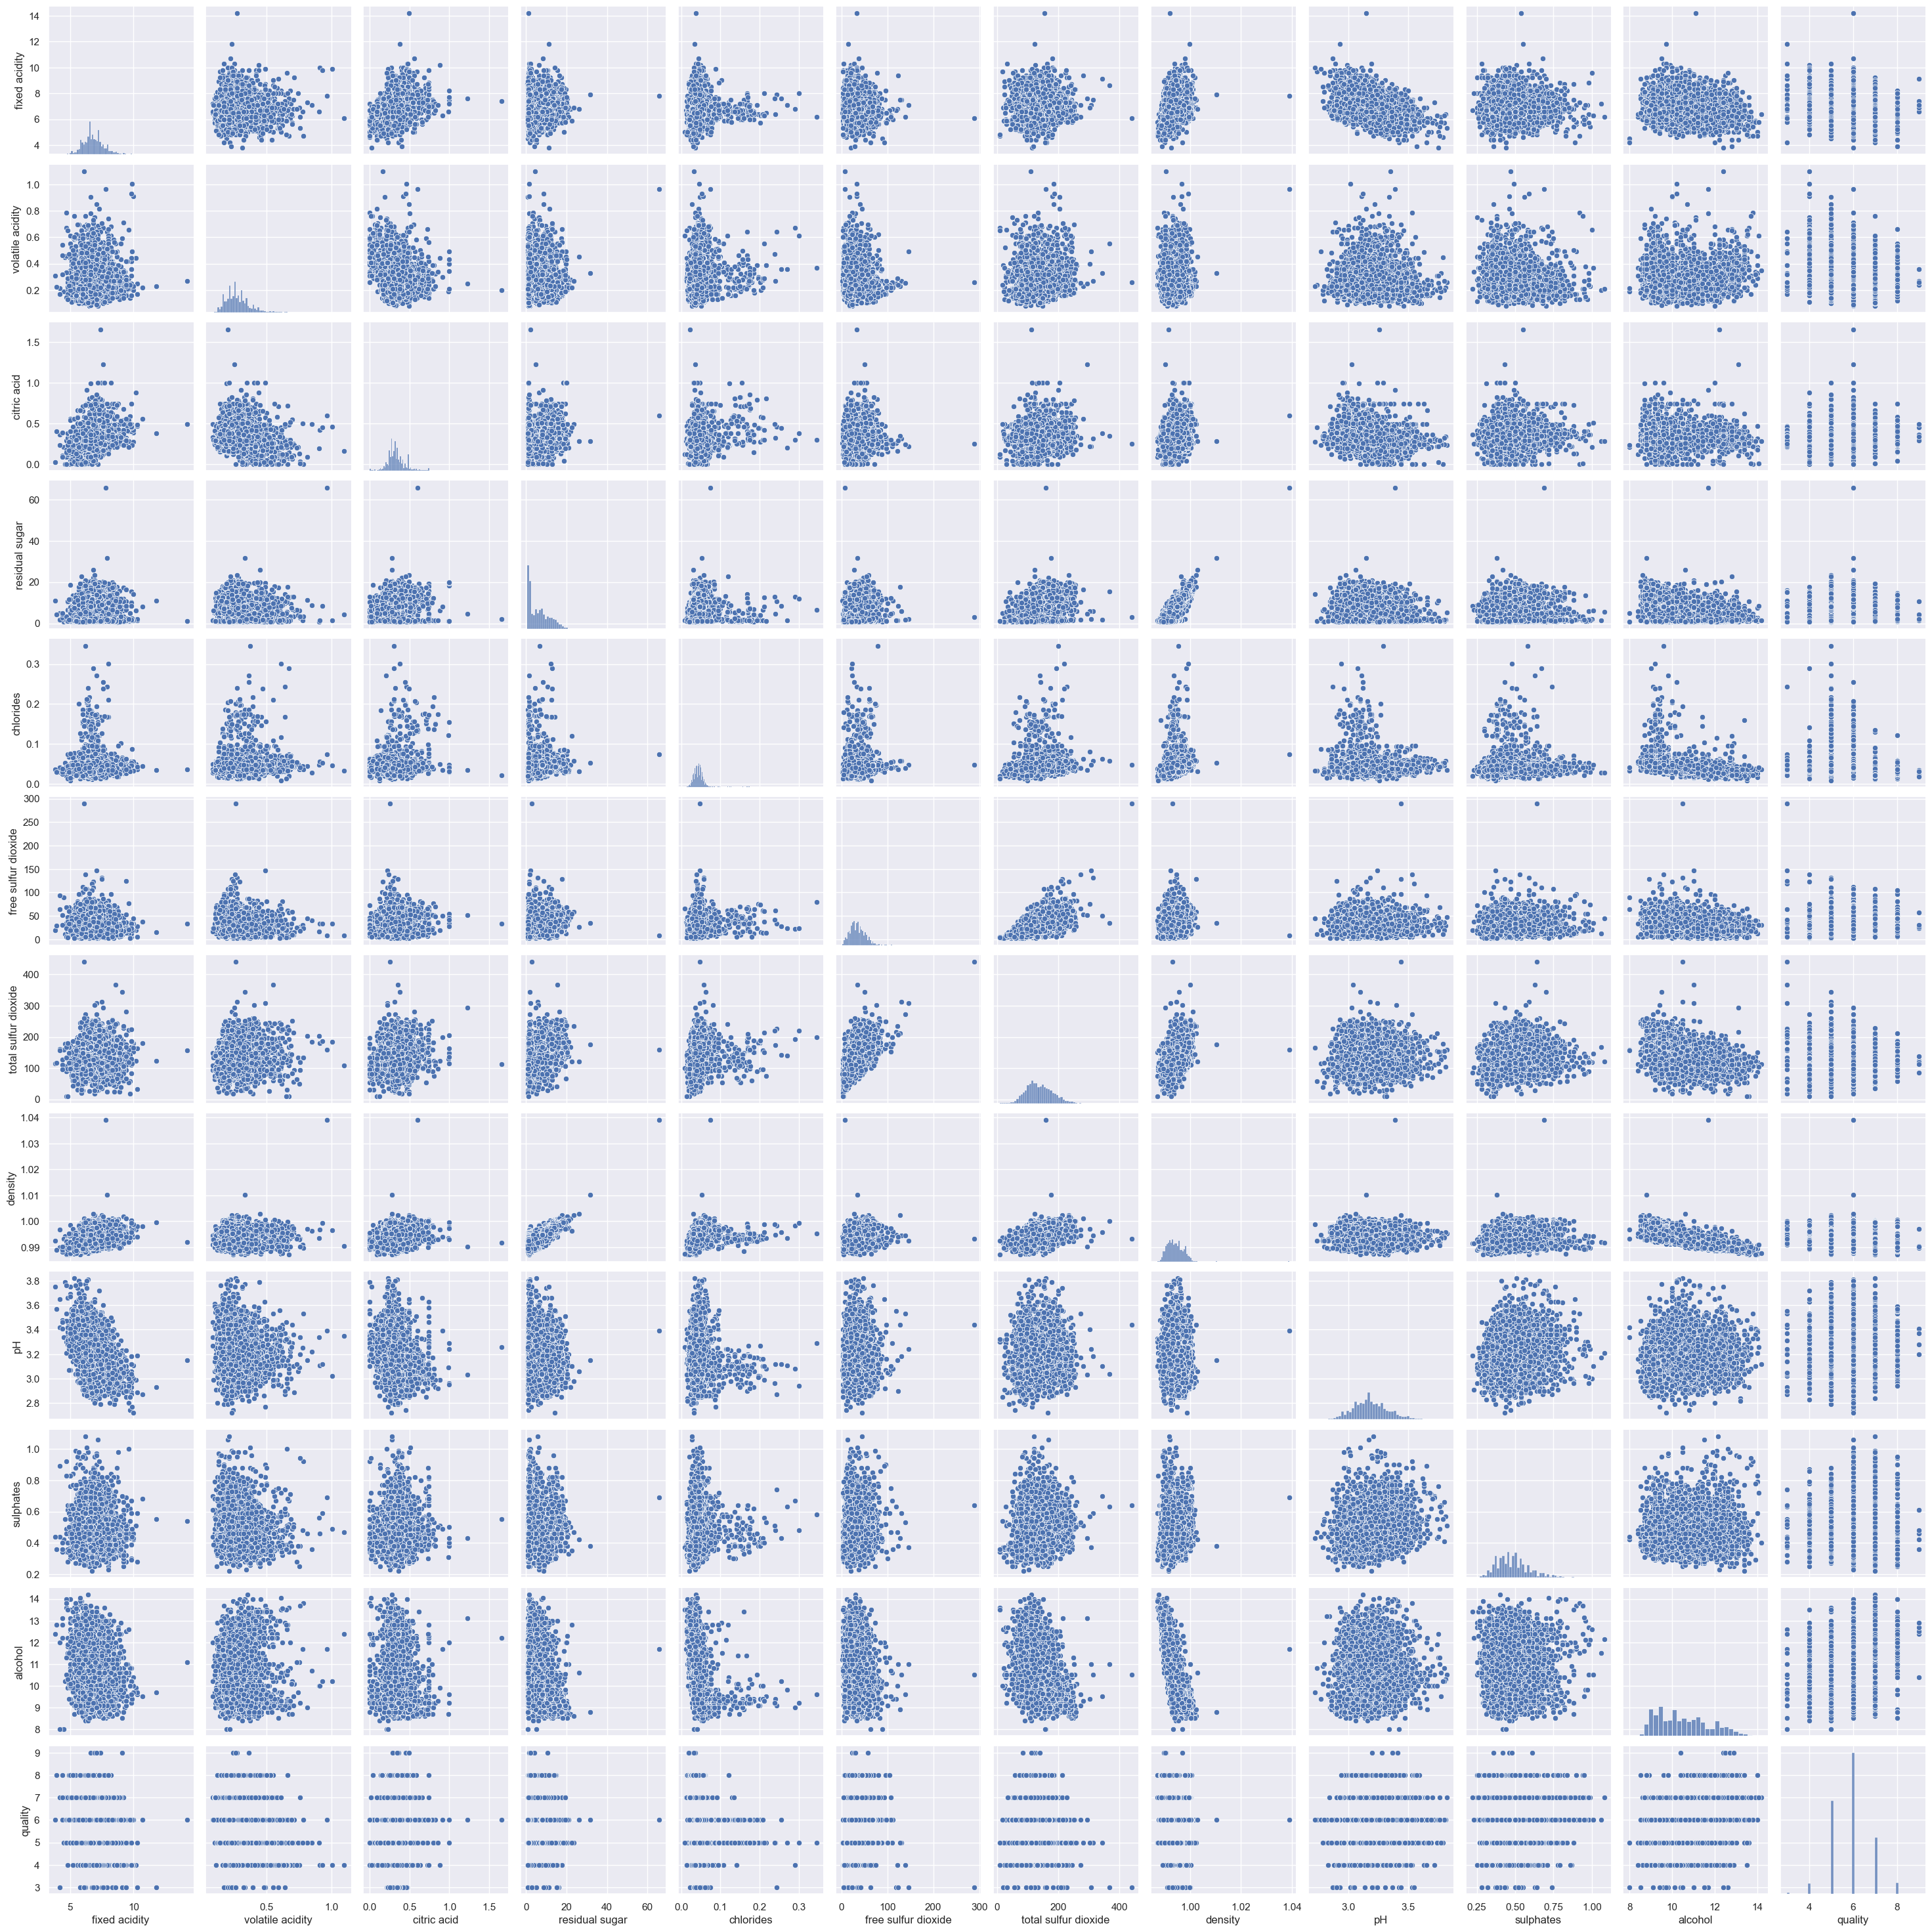

In [27]:
sns.set_theme()

sns.pairplot(
    data=wine_df
)

In [30]:
wine_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

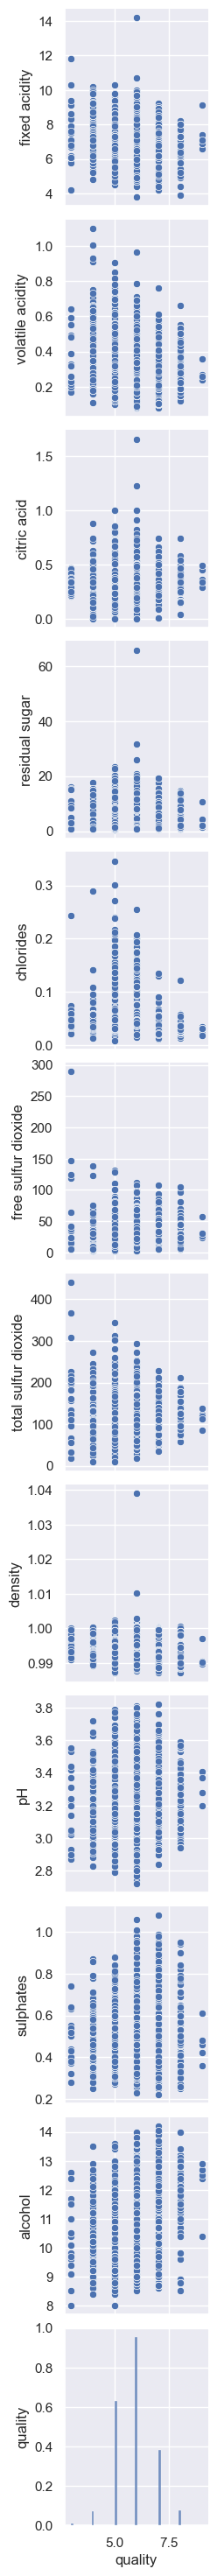

In [33]:
sns.pairplot(
    data=wine_df,
    y_vars=list(wine_df.columns),
    x_vars=["quality"]
)

We can see more clearly now that the quality indicator should be treated as a categorical or ordinal variable. Let's prepare the data into PyTorch.

In [34]:
wine_t: torch.Tensor = torch.from_numpy(
    wine_df.to_numpy()
)

In [57]:
wine_data_t: torch.Tensor = wine_t[:, :-1]
wine_target_t: torch.Tensor = wine_t[:, -1].long()

In [58]:
wine_data_t.shape, wine_target_t.shape

(torch.Size([4898, 11]), torch.Size([4898]))

### One-Hot Encoding

Since the quality is ordinal with ranking 0 through 10, let's use one-hot encoding

In [61]:
wine_target_1h_t: torch.Tensor = torch.zeros(wine_target_t.shape[0], 11)

In [63]:
wine_target_1h_t.scatter_(1, wine_target_t.unsqueeze(1), 1.0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

The `scatter_` method will not return a new tensor, but will instead modify the tensor in place. The arguments for `scatter_` are as follows:
 * The dimension along which the following two arguments are specified (`1`, in this case)
 * A column tensor indicating the indices of the elements to scatter (`wine_target_t.unsqueeze(1)`)
 * A tensor containing the elements to scatter or a single scalar to scatter (`1.0`)

In other words, the previous invocation reads, "For each row, take the index of the target label (which coincides with the score in our case) and use it as the column index to set the value 1.0." The end result is a tensor encoding categorical information.

Let's verify this with the first row

In [72]:
wine_target_t[0], wine_target_1h_t[0]

(tensor(6), tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

### Data Normalization

In [74]:
wine_data_mean, wine_data_std = torch.mean(wine_data_t), torch.std(wine_data_t)

In [75]:
wine_data_norm_t: torch.Tensor = (wine_data_t - wine_data_mean) / wine_data_std

In [78]:
wine_data_norm_mean, wine_data_norm_std = torch.mean(wine_data_norm_t), torch.std(wine_data_norm_t)
wine_data_norm_mean, wine_data_norm_std

(tensor(-1.7170e-08), tensor(1.))

Any deeper into this data set is not manipulating tensors, so let's move on.

## Time Series

Let's look at data where the ordering of the data is important. The dataset here is the 2011-2012 Washington, D.C., bike-sharing system at http://mng.bz/jgOx from the UCI Machine Learning site.

In [82]:
bike_hour_file = Path("Bike-Sharing-Dataset/hour.csv")
bike_day_file = Path("Bike-Sharing-Dataset/day.csv")

for filename in [bike_hour_file, bike_day_file]:
    with filename.open("r") as fh:
        print(filename)
        print("Header: ", fh.readline())
        print("First line", fh.readline())
        print("===")

Bike-Sharing-Dataset/hour.csv
Header:  instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt

First line 1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16

===
Bike-Sharing-Dataset/day.csv
Header:  instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt

First line 1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985

===


Looks like we got a mix of dates and real-valued measurements. Cursory examination at the two files shows that the days file is an aggregate of the hours file. Let's play with hour data.


In [113]:
bike_hour_names = [
    "instant",  # This is a row-counter
    "dteday",
    "season",  # 1-4 values for each of 4 seasons
    "yr",   # Year counter from 2011
    "mnth",  # Same month encoded in dteday
    "hr",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
    "casual",
    "registered",
    "cnt"
]
bike_hour_converters = dict.fromkeys(bike_hour_names, float)
bike_hour_converters["dteday"] = lambda x: float(x[8:10])  # Converts date strings %Y-%m-%d to day

In [114]:
bike_hour_df: pd.DataFrame = pd.read_csv(
    os.fspath(bike_hour_file),
    sep=",",
    names=bike_hour_names,
    header=0,
    converters=bike_hour_converters
)

In [115]:
bike_hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
2,3.0,1.0,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
3,4.0,1.0,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
4,5.0,1.0,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


Let's verify there are no gaps in the data. For each day, there should be 24 rows each.

<AxesSubplot: xlabel='hr', ylabel='Count'>

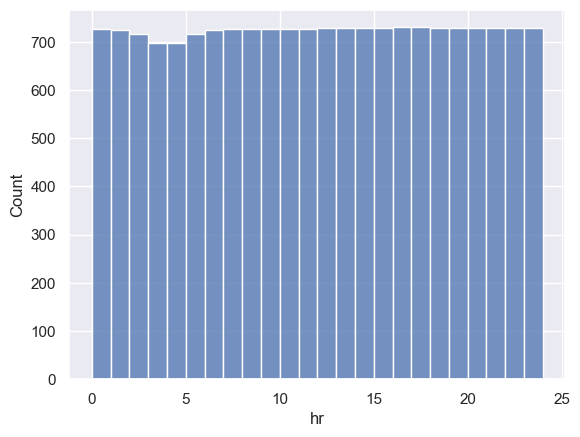

In [124]:
sns.histplot(bike_hour_df["hr"], bins=np.arange(0, 25))

We see a noticeable change in the data between 0-hours and 6-hours. This means some hours are missing!
For time-series data, there should be as little gap as possible to exploit causal relationships.

The procedure is to loop over each row and increment the hour modulo 24. If the expected hour is missing, add a with date information informing which date is appropriate

Fortunately, the tedious task of adding the missing data has been done by the authors of "Deep Learning with PyTorch" at https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/data/p1ch4/bike-sharing-dataset/hour-fixed.csv

In [144]:
bike_hour_fixed_file = Path("Bike-Sharing-Dataset/hour-fixed.csv")

bike_hour_fixed_df: pd.DataFrame = pd.read_csv(
    os.fspath(bike_hour_fixed_file),
    sep=",",
    names=bike_hour_names,
    header=0,
    converters=bike_hour_converters
)

Let's verify that there are no hour gaps. We can verify visually with a histogram and assert that there are the same number of hours in the file.

<AxesSubplot: xlabel='hr', ylabel='Count'>

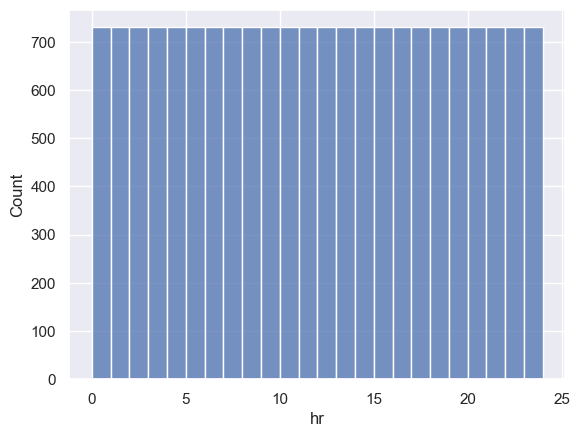

In [146]:
sns.histplot(bike_hour_fixed_df["hr"], bins=np.arange(0, 25))

In [170]:
assert len(set(Counter(bike_hour_fixed_df["hr"]).values())) == 1

How are missing data treated? We can reasonably assume that missing hours correspond to no counts "cnt". How are the other data filled?

In [171]:
row_index: int = 0
row: pd.Series
for row_index, row in bike_hour_fixed_df.iterrows():
    if not row.equals(bike_hour_df.iloc[row_index]):
        print("First different row", row_index)
        break

First different row 29


In [172]:
bike_hour_df.iloc[row_index-2:].head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
27,28.0,2.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.46,0.4545,0.94,0.1940,2.0,4.0,6.0
28,29.0,2.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,2.0,0.46,0.4545,0.94,0.1940,2.0,1.0,3.0
29,30.0,2.0,1.0,0.0,1.0,6.0,0.0,0.0,0.0,3.0,0.42,0.4242,0.77,0.2985,0.0,2.0,2.0
30,31.0,2.0,1.0,0.0,1.0,7.0,0.0,0.0,0.0,2.0,0.40,0.4091,0.76,0.1940,0.0,1.0,1.0
31,32.0,2.0,1.0,0.0,1.0,8.0,0.0,0.0,0.0,3.0,0.40,0.4091,0.71,0.2239,0.0,8.0,8.0


In [173]:
bike_hour_fixed_df.iloc[row_index-2:].head(6)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
27,28.0,2.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.46,0.4545,0.94,0.1940,2.0,4.0,6.0
28,29.0,2.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,2.0,0.46,0.4545,0.94,0.1940,2.0,1.0,3.0
29,29.0,2.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,2.0,0.46,0.4545,0.94,0.1940,2.0,1.0,0.0
30,30.0,2.0,1.0,0.0,1.0,6.0,0.0,0.0,0.0,3.0,0.42,0.4242,0.77,0.2985,0.0,2.0,2.0
31,31.0,2.0,1.0,0.0,1.0,7.0,0.0,0.0,0.0,2.0,0.40,0.4091,0.76,0.1940,0.0,1.0,1.0
32,32.0,2.0,1.0,0.0,1.0,8.0,0.0,0.0,0.0,3.0,0.40,0.4091,0.71,0.2239,0.0,8.0,8.0


We see that the data has been replicated from the previous row with the "cnt" set to 0. However, this is not in accordance with the dataset policy of "cnt" = "casual" + "registered". We need to fix this is we use this data next time.

In [174]:
bike_hours_fixed_t: torch.Tensor = torch.from_numpy(bike_hour_fixed_df.to_numpy())